# Курсовой проект

## Задача<a class="anchor" id="task"></a>

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения
2. Укажите свой ник на kaggle

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).

### Примерное описание этапов выполнения курсового проекта

**Построение модели классификации**
1. Обзор обучающего датасета
2. Анализ данных
3. Обработка пропусков
4. Обработка выбросов
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и построения признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Обзор данных
**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
* **Current Credit Balance** - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Подключение библиотек и скриптов

In [1]:
%%time
import pandas as pd
import numpy as np
import pickle
import random
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Wall time: 2.77 s


## Функции
### Обработка признаков

In [2]:
# обработка выбросов - замена на NaN
def preprocess_outlier_values(df, col, threshold):
    # можно по threshold отсекать, а можно и по квантилям
    df.loc[df[col] > threshold, col] = np.nan
    return df

In [3]:
# обработка пропусков - замена NaN медианой

### Метрики качества модели

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

In [5]:
def evaluate_preds(model, X_train, X_valid, y_train, y_valid):
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    print("TRAIN\n", round(f1_score(y_train, y_train_pred), 3))
    print("TEST\n", round(f1_score(y_valid, y_valid_pred), 3))
    get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

### Балансировка классов целевой переменной

In [6]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

### Подбор оптимального размера выборки, кривая обучения

In [7]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

### Выбор порога вероятности для определения класса

In [8]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

### Важность признаков

In [9]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

## Пути к директориям и файлам

In [10]:
DATA_ROOT = Path('./data_source/')
MODELS_PATH = Path('./models/')

# input
TRAIN_SET_PATH = DATA_ROOT / 'train.csv'
TEST_SET_PATH = DATA_ROOT / 'test.csv'
SAMPLE_SUBMIT_PATH = DATA_ROOT / 'sample_submission.csv'

# processing
PREPARED_TRAIN_SET_PATH = 'train_prep.csv' # X_train, X_valid
PREPARED_TEST_SET_PATH = 'test_prep.csv'

SPLIT_TRAIN_SET_PATH = 'split_train.csv'
SPLIT_VALID_SET_PATH = 'split_valid.csv'

SCALER_FILE_PATH = MODELS_PATH / 'scaler.pkl'
MODEL_FILE_PATH = MODELS_PATH / 'model.pkl'

# output
PREDICTIONS_FILE_PATH = 'predictions.csv'

#### Загрузка данных

In [11]:
df_train_base = pd.read_csv(TRAIN_SET_PATH)
df_test_base = pd.read_csv(TEST_SET_PATH)

In [12]:
df_train_base.shape

(7500, 17)

In [13]:
df_test_base.shape

(2500, 16)

## Анализ данных (EDA)
### Обзор обучающей выборки

In [14]:
df_train_base.head().T

,0,1,2,3,4
Home Ownership,Own Home,Own Home,Home Mortgage,Own Home,Rent
Annual Income,482087.0,1025487.0,751412.0,805068.0,776264.0
Years in current job,NaN,10+ years,8 years,6 years,8 years
Tax Liens,0.0,0.0,0.0,0.0,0.0
Number of Open Accounts,11.0,15.0,11.0,8.0,13.0
Years of Credit History,26.3,15.3,35.0,22.5,13.6
Maximum Open Credit,685960.0,1181730.0,1182434.0,147400.0,385836.0
Number of Credit Problems,1.0,0.0,0.0,1.0,1.0
Months since last delinquent,NaN,NaN,NaN,NaN,NaN
Bankruptcies,1.0,0.0,0.0,1.0,0.0


In [15]:
df_train_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Из описания обучающей выборки видим, что есть пропуски в признаках:
 - Annual Income
 - Years in current job
 - Months since last delinquent
 - Credit Score
 - Bankruptcies

In [16]:
df_train_base.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


#### Выделение целевой переменной и групп признаков

In [17]:
TARGET_NAME_BASE = 'Credit Default'

NUM_FEATURE_NAMES_BASE = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                     'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                     'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                     'Credit Score']

CAT_FEATURE_NAMES_BASE = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

#### Анализ значений целевой переменной

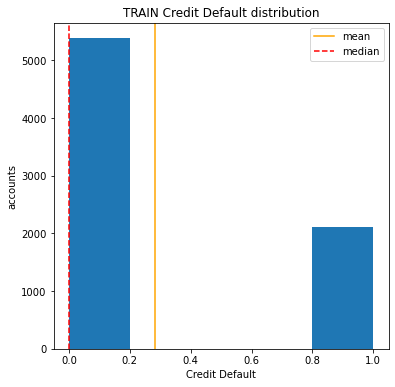

In [18]:
df_train_base[TARGET_NAME_BASE].hist(figsize=(6, 6), bins=5, grid=False)
plt.axvline(x=df_train_base['Credit Default'].mean(),
            label='mean', color='orange')
plt.axvline(x=df_train_base['Credit Default'].median(
), label='median', linestyle='--', color='red')
plt.ylabel('accounts')
plt.xlabel('Credit Default')
plt.title('TRAIN Credit Default distribution')
plt.legend()
plt.show()

In [19]:
df_train_base[TARGET_NAME_BASE].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Соотношение класов в целевой переменной примерно 2 к 1. Дисбаланс классов присутствует, но его влияние на результат предсказаний не слишком велико. При построении модели можно будет сделать балансировку классов.

#### Анализ числовых признаков

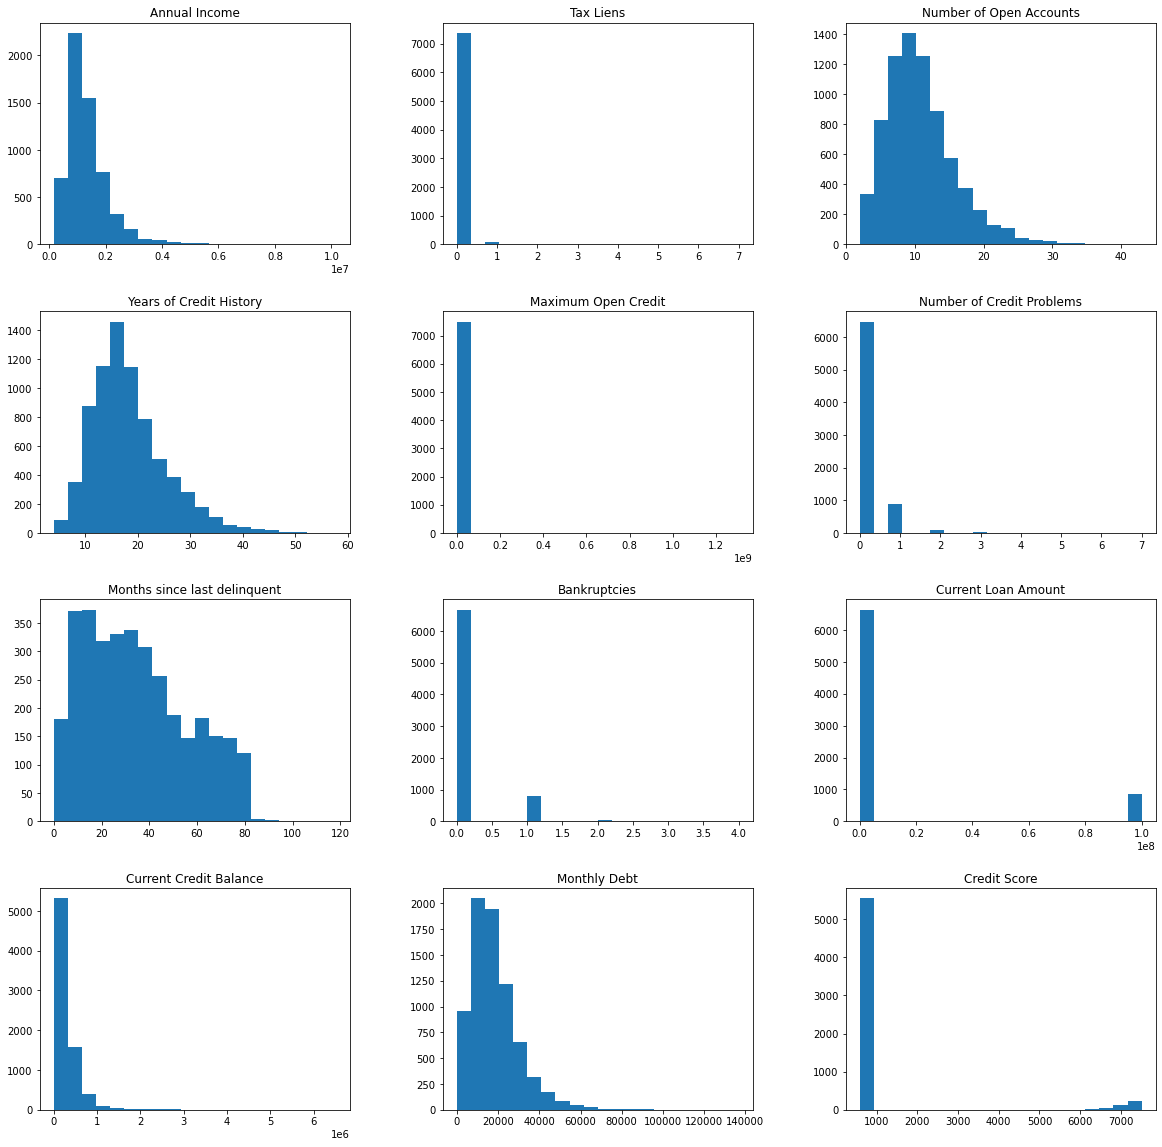

In [20]:
df_train_base[NUM_FEATURE_NAMES_BASE].hist(figsize=(20, 20), bins=20, grid=False);

In [21]:
for num_colname in df_train_base.select_dtypes(include='float64').columns:
    print(str(num_colname) + '\n\n' + str(df_train_base[num_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Annual Income

1338113.0    4
969475.0     4
1161660.0    4
1043651.0    4
1058376.0    4
            ..
1272316.0    1
712082.0     1
695476.0     1
678889.0     1
402192.0     1
Name: Annual Income, Length: 5478, dtype: int64
****************************************************************************************************

Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Open Accounts

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
32.0      6
33.0      6
31.0      6
34.0      2
37.0      

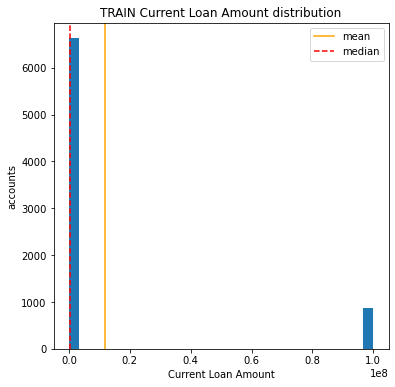

In [22]:
df_train_base['Current Loan Amount'].hist(
    figsize=(6, 6), bins=30, grid=False)
plt.axvline(x=df_train_base['Current Loan Amount'].mean(),
            label='mean', color='orange')
plt.axvline(x=df_train_base['Current Loan Amount'].median(
), label='median', linestyle='--', color='red')
plt.ylabel('accounts')
plt.xlabel('Current Loan Amount')
plt.title('TRAIN Current Loan Amount distribution')
plt.legend()
plt.show()

In [23]:
Current_Loan_Amount_gap_filter = df_train_base['Current Loan Amount'] > 99999000
df_train_base.loc[Current_Loan_Amount_gap_filter]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
22,Rent,463790.0,NaN,0.0,6.0,28.3,288442.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,157700.0,5063.0,738.0,0
27,Rent,1004055.0,8 years,0.0,7.0,14.5,328394.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,195966.0,6041.0,734.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7441,Rent,1406836.0,1 year,0.0,12.0,22.6,2383260.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,461054.0,7386.0,747.0,0
7445,Home Mortgage,1564384.0,6 years,0.0,21.0,17.3,1545016.0,0.0,NaN,0.0,other,Long Term,99999999.0,1043442.0,32461.0,728.0,0
7464,Home Mortgage,1159152.0,6 years,0.0,14.0,22.0,389356.0,1.0,77.0,1.0,debt consolidation,Short Term,99999999.0,49438.0,18257.0,737.0,0
7475,Rent,848426.0,10+ years,0.0,8.0,20.1,526306.0,0.0,12.0,0.0,debt consolidation,Short Term,99999999.0,83638.0,16473.0,742.0,0


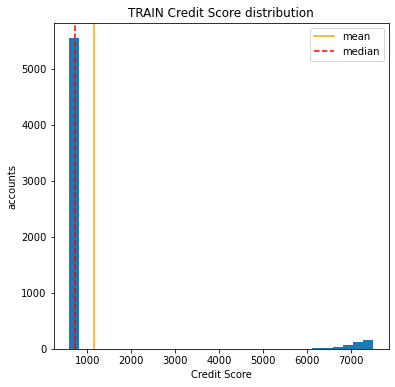

In [24]:
df_train_base['Credit Score'].hist(figsize=(6, 6), bins=30, grid=False)
plt.axvline(x=df_train_base['Credit Score'].mean(),
            label='mean', color='orange')
plt.axvline(x=df_train_base['Credit Score'].median(
), label='median', linestyle='--', color='red')
plt.ylabel('accounts')
plt.xlabel('Credit Score')
plt.title('TRAIN Credit Score distribution')
plt.legend()
plt.show()

In [25]:
Credit_Score_gap_filter = df_train_base['Credit Score'] > 1000
df_train_base.loc[Credit_Score_gap_filter]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
69,Home Mortgage,1408527.0,2 years,0.0,12.0,17.5,700062.0,0.0,21.0,0.0,other,Long Term,525998.0,174135.0,9320.0,6470.0,1
87,Home Mortgage,1533566.0,7 years,0.0,11.0,14.8,715462.0,0.0,19.0,0.0,debt consolidation,Short Term,210826.0,285475.0,18147.0,7440.0,1
94,Rent,1049294.0,3 years,0.0,5.0,6.1,249810.0,0.0,NaN,0.0,business loan,Short Term,337502.0,119529.0,15215.0,7010.0,1
96,Rent,757568.0,5 years,0.0,13.0,11.4,383548.0,0.0,NaN,0.0,debt consolidation,Short Term,210518.0,276583.0,11553.0,7320.0,1
116,Home Mortgage,1039984.0,NaN,0.0,10.0,23.8,147950.0,0.0,63.0,0.0,debt consolidation,Short Term,224246.0,95456.0,13780.0,7390.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7422,Rent,694868.0,1 year,0.0,4.0,7.8,143066.0,0.0,NaN,0.0,debt consolidation,Long Term,244178.0,122075.0,4268.0,6690.0,1
7433,Rent,2011758.0,< 1 year,0.0,4.0,14.9,22176.0,0.0,43.0,0.0,buy a car,Long Term,106480.0,18791.0,12590.0,6060.0,1
7450,Home Mortgage,1432277.0,10+ years,0.0,16.0,22.8,825176.0,0.0,NaN,0.0,debt consolidation,Short Term,187924.0,458242.0,27094.0,7290.0,1
7460,Rent,769462.0,5 years,0.0,8.0,17.0,313786.0,0.0,80.0,0.0,debt consolidation,Short Term,109186.0,45524.0,4585.0,7470.0,1


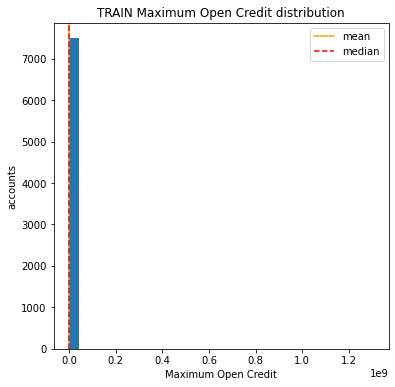

In [26]:
df_train_base['Maximum Open Credit'].hist(figsize=(6, 6), bins=30, grid=False)
plt.axvline(x=df_train_base['Maximum Open Credit'].mean(),
            label='mean', color='orange')
plt.axvline(x=df_train_base['Maximum Open Credit'].median(
), label='median', linestyle='--', color='red')
plt.ylabel('accounts')
plt.xlabel('Maximum Open Credit')
plt.title('TRAIN Maximum Open Credit distribution')
plt.legend()
plt.show()

In [27]:
Maximum_Open_Credit_gap_filter = df_train_base['Maximum Open Credit'] > 99999000
df_train_base.loc[Maximum_Open_Credit_gap_filter]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
44,Have Mortgage,1334256.0,10+ years,0.0,17.0,15.4,3.800523e+08,1.0,35.0,0.0,take a trip,Short Term,33110.0,656450.0,34357.0,729.0,0
617,Home Mortgage,NaN,3 years,0.0,13.0,27.5,1.304726e+09,0.0,NaN,0.0,debt consolidation,Short Term,529892.0,1126814.0,5492.0,NaN,0
2617,Home Mortgage,3217802.0,10+ years,0.0,12.0,35.5,2.655129e+08,0.0,NaN,0.0,other,Short Term,50116.0,1834450.0,20272.0,750.0,0


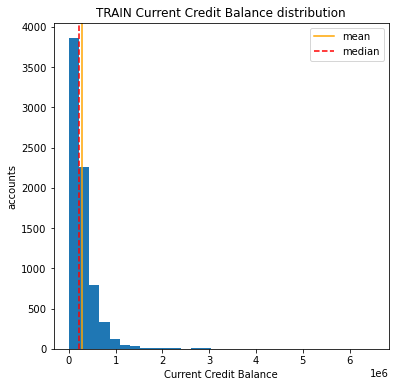

In [28]:
df_train_base['Current Credit Balance'].hist(figsize=(6, 6), bins=30, grid=False)
plt.axvline(x=df_train_base['Current Credit Balance'].mean(),
            label='mean', color='orange')
plt.axvline(x=df_train_base['Current Credit Balance'].median(
), label='median', linestyle='--', color='red')
plt.ylabel('accounts')
plt.xlabel('Current Credit Balance')
plt.title('TRAIN Current Credit Balance distribution')
plt.legend()
plt.show()

In [29]:
Current_Credit_Balance_gap_filter = df_train_base['Current Credit Balance'] > 1000000
df_train_base.loc[Current_Credit_Balance_gap_filter]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
13,Rent,2066364.0,10+ years,0.0,11.0,17.7,1654026.0,0.0,NaN,0.0,debt consolidation,Long Term,549780.0,1037077.0,21869.0,728.0,1
14,Own Home,2258796.0,7 years,0.0,11.0,17.7,1602546.0,0.0,NaN,0.0,other,Short Term,185262.0,1374327.0,58352.0,748.0,0
25,Rent,1353142.0,10+ years,0.0,3.0,29.8,1231912.0,0.0,NaN,0.0,other,Short Term,108042.0,1036279.0,22225.0,720.0,0
93,Home Mortgage,NaN,10+ years,0.0,18.0,17.9,3028014.0,0.0,NaN,0.0,debt consolidation,Short Term,311168.0,2327443.0,55716.0,NaN,0
133,Home Mortgage,1878910.0,10+ years,0.0,17.0,21.7,4477858.0,0.0,1.0,0.0,debt consolidation,Short Term,326348.0,1009356.0,16441.0,693.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377,Home Mortgage,1844292.0,10+ years,0.0,13.0,19.7,5784482.0,0.0,6.0,0.0,debt consolidation,Long Term,265078.0,1673558.0,12833.0,698.0,0
7404,Home Mortgage,NaN,10+ years,0.0,21.0,16.2,2468026.0,0.0,NaN,0.0,debt consolidation,Short Term,400004.0,1157385.0,42990.0,NaN,1
7445,Home Mortgage,1564384.0,6 years,0.0,21.0,17.3,1545016.0,0.0,NaN,0.0,other,Long Term,99999999.0,1043442.0,32461.0,728.0,0
7459,Home Mortgage,NaN,9 years,3.0,21.0,12.1,1547854.0,3.0,37.0,0.0,debt consolidation,Short Term,458854.0,1149614.0,85030.0,NaN,0


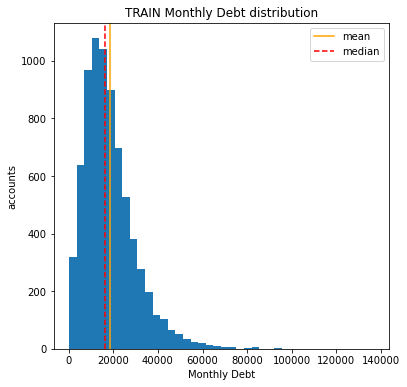

In [30]:
df_train_base['Monthly Debt'].hist(figsize=(6, 6), bins=40, grid=False)
plt.axvline(x=df_train_base['Monthly Debt'].mean(),
            label='mean', color='orange')
plt.axvline(x=df_train_base['Monthly Debt'].median(
), label='median', linestyle='--', color='red')
plt.ylabel('accounts')
plt.xlabel('Monthly Debt')
plt.title('TRAIN Monthly Debt distribution')
plt.legend()
plt.show()

In [31]:
Monthly_Debt_gap_filter = df_train_base['Monthly Debt'] > 60000
df_train_base.loc[Monthly_Debt_gap_filter]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
164,Home Mortgage,2899305.0,10+ years,0.0,15.0,16.6,667480.0,0.0,NaN,0.0,debt consolidation,Long Term,783332.0,328016.0,64751.0,709.0,0
166,Home Mortgage,4580976.0,4 years,0.0,18.0,25.5,1553530.0,0.0,NaN,0.0,debt consolidation,Long Term,99999999.0,633289.0,94674.0,727.0,0
181,Home Mortgage,NaN,3 years,0.0,17.0,20.6,1824306.0,0.0,47.0,0.0,debt consolidation,Long Term,626538.0,967385.0,63515.0,NaN,0
193,Home Mortgage,NaN,10+ years,0.0,21.0,29.4,1714966.0,0.0,4.0,0.0,debt consolidation,Short Term,695068.0,503576.0,67783.0,NaN,1
265,Home Mortgage,3542075.0,10+ years,0.0,13.0,26.5,846582.0,0.0,NaN,0.0,debt consolidation,Long Term,421212.0,628064.0,60805.0,731.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097,Rent,7660648.0,4 years,0.0,14.0,32.2,1187406.0,0.0,31.0,0.0,medical bills,Short Term,173492.0,783465.0,72138.0,687.0,0
7179,Home Mortgage,3709940.0,5 years,0.0,5.0,15.4,899030.0,0.0,NaN,0.0,debt consolidation,Short Term,429572.0,277191.0,83783.0,748.0,1
7459,Home Mortgage,NaN,9 years,3.0,21.0,12.1,1547854.0,3.0,37.0,0.0,debt consolidation,Short Term,458854.0,1149614.0,85030.0,NaN,0
7478,Home Mortgage,3888160.0,6 years,0.0,30.0,16.3,1435456.0,0.0,21.0,0.0,debt consolidation,Short Term,787864.0,402914.0,93640.0,703.0,0


**В обучающем (TRAIN) сете имеются выбросы в следующих признаках:**<br>
 - 870 значений в признаке `Current Loan Amount` равны 99 999 999.0, остальные меньше 1 000 000 $\Rightarrow$ замена на `NaN` и далее обработка в качестве пропусков.
 - 400 значений признака `Credit Score` более 1000. Все они кратны 10 и находятся в диапазоне от 6 000 до 7 500:
   - Можно убрать эти выбросы путем деления значений на 10 и тогда они будут в диапазоне большинства значений по этому признаку.
   - Также в данном признаке имеется большое количество пропусков $\Rightarrow$ можно заменить выбросы на `NaN` и далее обработать как пропуски.
 - 3 значения `Maximum Open Credit` более 99 999 999.

Также к выбросам можно отнести:
 - 188 значений `Current Credit Balance` более 1 000 000;
 - 67 значений `Monthly Debt` более 60 000.

Во время финальной доработки модели можно будет их обработать.

#### Анализ категориальных признаков

In [32]:
for cat_colname in df_train_base.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train_base[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

#### Корреляция признаков с целевой переменной

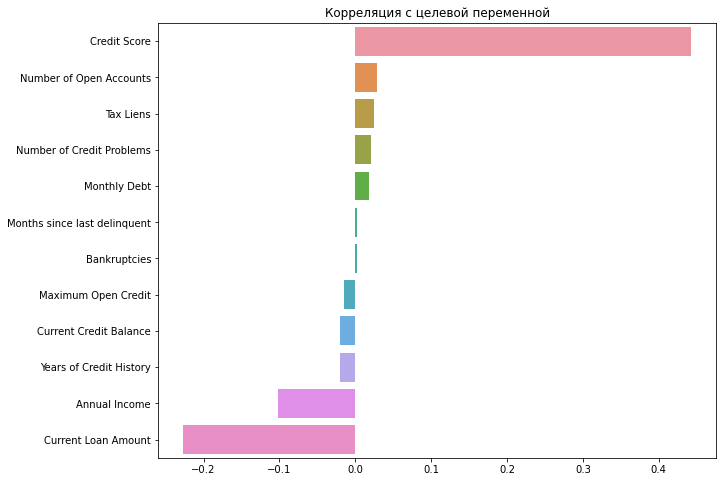

In [33]:
corr_with_target = df_train_base[NUM_FEATURE_NAMES_BASE + [TARGET_NAME_BASE]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Корреляция с целевой переменной')
plt.show()

**Наблюдаем сильную прямую корреляцию целевой переменной с количественным признаком `'Credit Score'` и обратную корреляцию с признаками `'Annual Income'` и `'Current Loan Amount'`. Повышение качества модели будет происходить за счет коррекции (обработки выбросов/пропусков) в первую очередь этих признаков.**

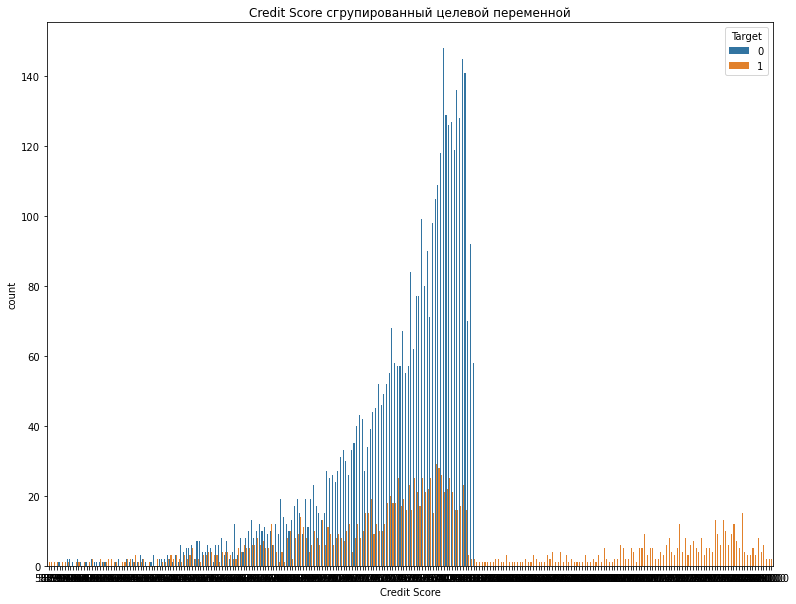

Wall time: 2.59 s


In [34]:
%%time
plt.figure(figsize=(13, 10))

sns.countplot(x="Credit Score", hue=TARGET_NAME_BASE, data=df_train_base)
plt.title('Credit Score сгрупированный целевой переменной')
plt.legend(title='Target', loc='upper right')

plt.show()

### Обзор тестовой выборки

In [35]:
df_test_base.head().T

,0,1,2,3,4
Home Ownership,Rent,Rent,Home Mortgage,Home Mortgage,Home Mortgage
Annual Income,NaN,231838.0,1152540.0,1220313.0,2340952.0
Years in current job,4 years,1 year,3 years,10+ years,6 years
Tax Liens,0.0,0.0,0.0,0.0,0.0
Number of Open Accounts,9.0,6.0,10.0,16.0,11.0
Years of Credit History,12.5,32.7,13.7,17.0,23.6
Maximum Open Credit,220968.0,55946.0,204600.0,456302.0,1207272.0
Number of Credit Problems,0.0,0.0,0.0,0.0,0.0
Months since last delinquent,70.0,8.0,NaN,70.0,NaN
Bankruptcies,0.0,0.0,0.0,0.0,0.0


In [36]:
df_test_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

Из описания тестовой выборки видим, что есть пропуски в признаках:
 - Annual Income
 - Years in current job
 - Months since last delinquent
 - Credit Score
 - Bankruptcies
 
Пропуски в тех же признаках, что и в обучающей выборке.

In [37]:
df_test_base.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,1987.0,1.366922e+06,9.171252e+05,106533.0,852311.50,1178475.0,1629734.5,14975610.0
Tax Liens,2500.0,3.520000e-02,3.862909e-01,0.0,0.00,0.0,0.0,15.0
Number of Open Accounts,2500.0,1.118440e+01,4.852774e+00,1.0,8.00,10.0,14.0,48.0
Years of Credit History,2500.0,1.832592e+01,7.254659e+00,3.9,13.40,17.0,22.1,53.4
Maximum Open Credit,2500.0,7.105704e+05,1.511983e+06,0.0,278586.00,478676.0,802598.5,54484386.0
Number of Credit Problems,2500.0,1.620000e-01,5.598941e-01,0.0,0.00,0.0,0.0,15.0
Months since last delinquent,1142.0,3.418126e+01,2.202428e+01,0.0,16.00,30.0,50.0,82.0
Bankruptcies,2497.0,1.069283e-01,3.571893e-01,0.0,0.00,0.0,0.0,5.0
Current Loan Amount,2500.0,1.215572e+07,3.226097e+07,15422.0,187126.50,322366.0,522582.5,99999999.0
Current Credit Balance,2500.0,2.963966e+05,3.783020e+05,0.0,110114.50,207385.0,366348.5,6030087.0


#### Анализ числовых признаков

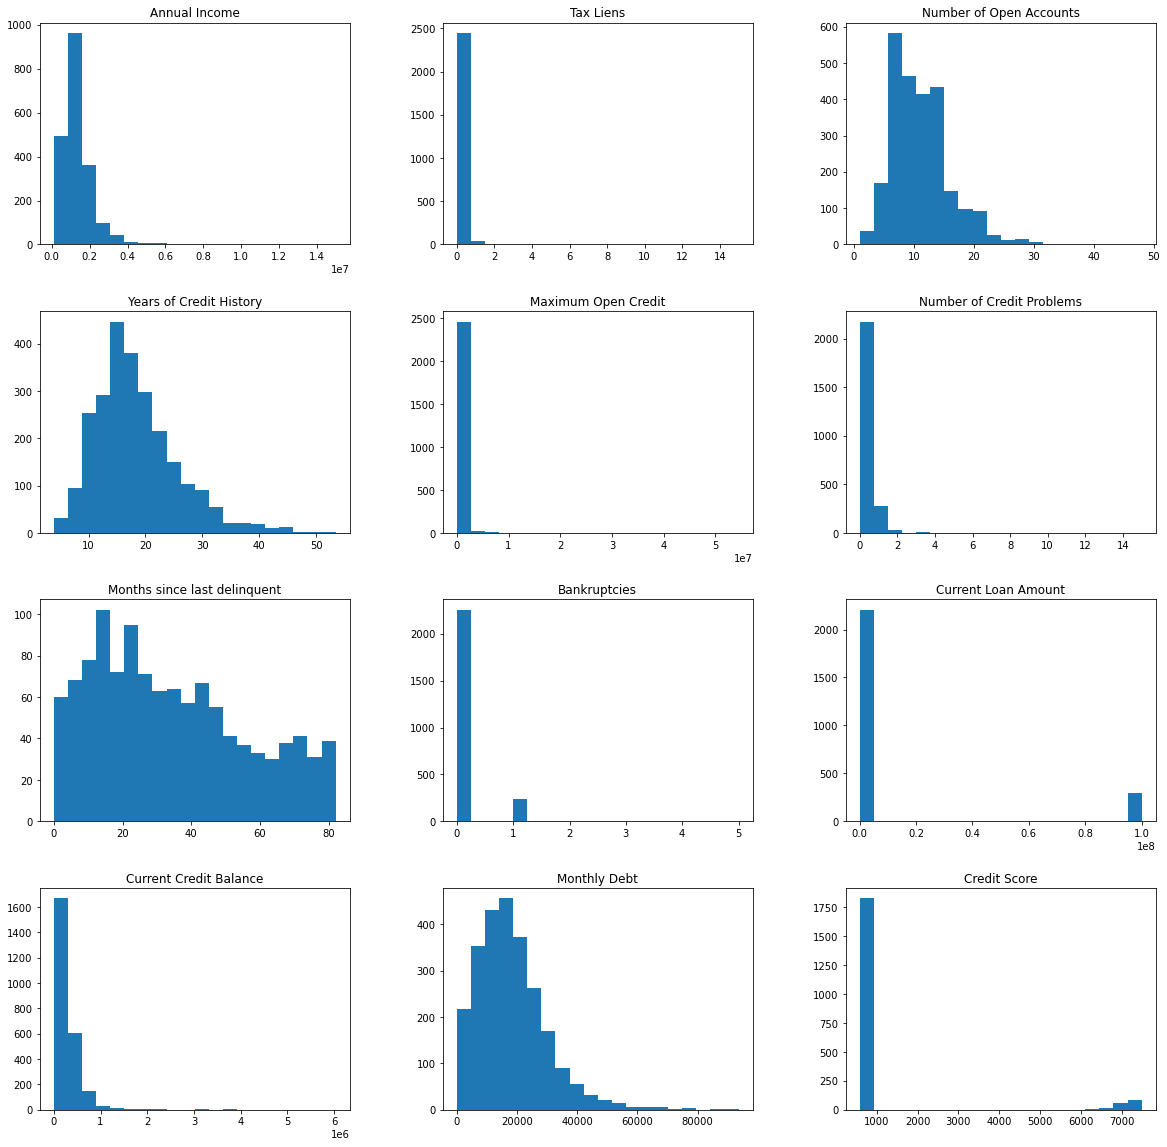

In [38]:
df_test_base[NUM_FEATURE_NAMES_BASE].hist(figsize=(20, 20), bins=20, grid=False);

In [39]:
for num_colname in df_test_base.select_dtypes(include='float64').columns:
    print(str(num_colname) + '\n\n' + str(df_test_base[num_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Annual Income

1025145.0    3
1328803.0    3
1214993.0    3
1237109.0    3
1204619.0    2
            ..
763838.0     1
1221168.0    1
651377.0     1
1735479.0    1
1694439.0    1
Name: Annual Income, Length: 1929, dtype: int64
****************************************************************************************************

Tax Liens

0.0     2445
1.0       45
2.0        5
5.0        1
4.0        1
6.0        1
3.0        1
15.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Open Accounts

9.0     245
8.0     223
10.0    218
11.0    211
12.0    204
6.0     183
13.0    178
7.0     176
14.0    159
5.0     106
15.0     97
16.0     81
17.0     66
4.0      63
18.0     52
19.0     46
20.0     37
21.0     29
3.0      29
22.0     26
23.0     17
27.0     10
24.0      9
2.0       7
30.0      6
25.0      6
26.0      5
28.0      3
33.0      2
31.0      1
1.0       1
36.0      1
29.0      1
34

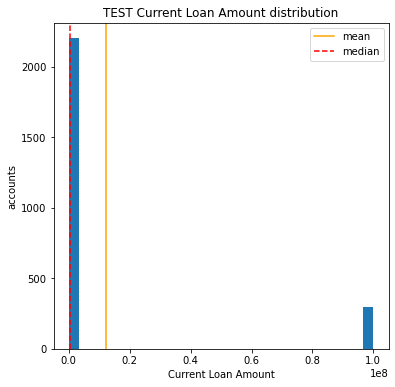

In [40]:
df_test_base['Current Loan Amount'].hist(
    figsize=(6, 6), bins=30, grid=False)
plt.axvline(x=df_test_base['Current Loan Amount'].mean(),
            label='mean', color='orange')
plt.axvline(x=df_test_base['Current Loan Amount'].median(
), label='median', linestyle='--', color='red')
plt.ylabel('accounts')
plt.xlabel('Current Loan Amount')
plt.title('TEST Current Loan Amount distribution')
plt.legend()
plt.show()

In [41]:
Current_Loan_Amount_gap_filter = df_test_base['Current Loan Amount'] > 99999000
df_test_base.loc[Current_Loan_Amount_gap_filter]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
17,Home Mortgage,1246495.0,9 years,0.0,10.0,22.9,357456.0,0.0,40.0,0.0,debt consolidation,Short Term,99999999.0,294823.0,21086.0,729.0
22,Own Home,960735.0,8 years,0.0,17.0,11.8,512380.0,0.0,29.0,0.0,debt consolidation,Short Term,99999999.0,164179.0,17133.0,733.0
33,Rent,743888.0,1 year,0.0,11.0,20.0,927124.0,0.0,18.0,0.0,debt consolidation,Short Term,99999999.0,303468.0,15002.0,735.0
45,Home Mortgage,1768729.0,10+ years,0.0,11.0,19.7,3462558.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,1764321.0,29184.0,737.0
59,Rent,1984512.0,5 years,0.0,11.0,10.5,286088.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,134653.0,25964.0,745.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2444,Rent,5997920.0,2 years,0.0,11.0,17.6,1178584.0,0.0,46.0,0.0,debt consolidation,Short Term,99999999.0,350151.0,39686.0,750.0
2457,Home Mortgage,1437502.0,10+ years,0.0,16.0,13.0,750970.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,71991.0,25396.0,747.0
2461,Rent,613225.0,3 years,0.0,6.0,16.8,188078.0,0.0,NaN,0.0,other,Short Term,99999999.0,13319.0,7665.0,749.0
2467,Home Mortgage,939075.0,4 years,0.0,21.0,16.7,577940.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,269534.0,17216.0,737.0


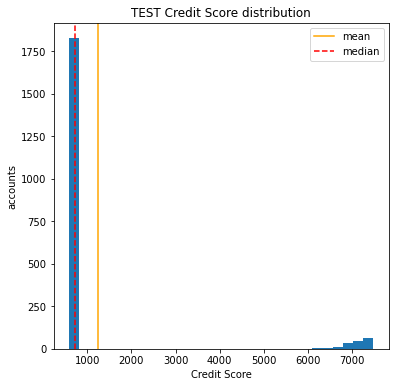

In [42]:
df_test_base['Credit Score'].hist(figsize=(6, 6), bins=30, grid=False)
plt.axvline(x=df_test_base['Credit Score'].mean(),
            label='mean', color='orange')
plt.axvline(x=df_test_base['Credit Score'].median(
), label='median', linestyle='--', color='red')
plt.ylabel('accounts')
plt.xlabel('Credit Score')
plt.title('TEST Credit Score distribution')
plt.legend()
plt.show()

In [43]:
Credit_Score_gap_filter = df_test_base['Credit Score'] > 1000
df_test_base.loc[Credit_Score_gap_filter]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
12,Home Mortgage,1054614.0,2 years,0.0,11.0,14.0,306328.0,0.0,69.0,0.0,debt consolidation,Short Term,155408.0,202388.0,14940.0,7030.0
41,Home Mortgage,1735498.0,1 year,0.0,10.0,13.2,1584506.0,0.0,NaN,0.0,debt consolidation,Short Term,777172.0,758119.0,30371.0,7320.0
54,Home Mortgage,1602403.0,9 years,0.0,13.0,18.9,690514.0,0.0,47.0,0.0,home improvements,Long Term,695266.0,365560.0,16959.0,6340.0
58,Home Mortgage,1238895.0,6 years,0.0,22.0,17.5,939378.0,0.0,NaN,0.0,debt consolidation,Short Term,393866.0,499757.0,26017.0,7140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2449,Home Mortgage,1030902.0,10+ years,0.0,14.0,25.8,871838.0,0.0,NaN,0.0,debt consolidation,Long Term,533346.0,430692.0,27319.0,7300.0
2470,Home Mortgage,1116972.0,8 years,0.0,8.0,14.0,351560.0,0.0,NaN,0.0,debt consolidation,Long Term,258676.0,239552.0,14521.0,6470.0
2472,Home Mortgage,1951110.0,< 1 year,0.0,13.0,24.1,440506.0,1.0,NaN,1.0,debt consolidation,Short Term,129096.0,92454.0,25852.0,7410.0
2477,Rent,667603.0,2 years,0.0,5.0,12.3,333366.0,0.0,NaN,0.0,debt consolidation,Short Term,220858.0,152589.0,7622.0,7480.0


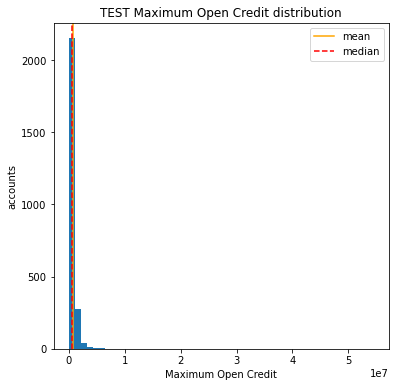

In [44]:
df_test_base['Maximum Open Credit'].hist(
    figsize=(6, 6), bins=50, grid=False)
plt.axvline(x=df_test_base['Maximum Open Credit'].mean(),
            label='mean', color='orange')
plt.axvline(x=df_test_base['Maximum Open Credit'].median(
), label='median', linestyle='--', color='red')
plt.ylabel('accounts')
plt.xlabel('Maximum Open Credit')
plt.title('TEST Maximum Open Credit distribution')
plt.legend()
plt.show()

In [45]:
df_test_base.nlargest(5, 'Maximum Open Credit')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
228,Home Mortgage,3356255.0,10+ years,0.0,20.0,17.2,54484386.0,0.0,NaN,0.0,home improvements,Long Term,777238.0,5176018.0,42792.0,695.0
1568,Home Mortgage,1236292.0,10+ years,0.0,18.0,32.8,26069956.0,0.0,NaN,0.0,buy a car,Short Term,65560.0,697965.0,23232.0,751.0
2152,Home Mortgage,NaN,10+ years,0.0,16.0,32.3,20842404.0,0.0,NaN,0.0,debt consolidation,Short Term,612502.0,6030087.0,75206.0,NaN
584,Home Mortgage,1313413.0,7 years,0.0,11.0,21.5,19185386.0,0.0,40.0,0.0,other,Long Term,495660.0,2236832.0,6906.0,743.0
222,Home Mortgage,2807535.0,10+ years,0.0,12.0,19.3,15568542.0,0.0,NaN,0.0,buy house,Short Term,99999999.0,3240374.0,27607.0,750.0


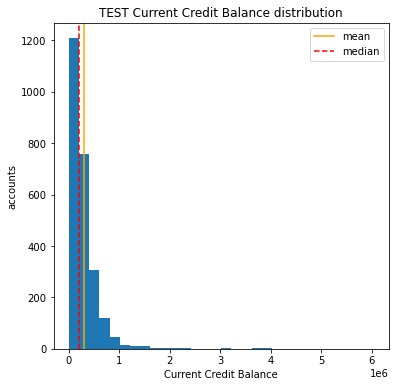

In [46]:
df_test_base['Current Credit Balance'].hist(
    figsize=(6, 6), bins=30, grid=False)
plt.axvline(x=df_test_base['Current Credit Balance'].mean(),
            label='mean', color='orange')
plt.axvline(x=df_test_base['Current Credit Balance'].median(
), label='median', linestyle='--', color='red')
plt.ylabel('accounts')
plt.xlabel('Current Credit Balance')
plt.title('TEST Current Credit Balance distribution')
plt.legend()
plt.show()

In [47]:
Current_Credit_Balance_gap_filter = df_test_base['Current Credit Balance'] > 1000000
df_test_base.loc[Current_Credit_Balance_gap_filter]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
42,Rent,NaN,5 years,0.0,30.0,15.8,1661484.0,0.0,NaN,0.0,other,Long Term,296560.0,1093412.0,68721.0,NaN
45,Home Mortgage,1768729.0,10+ years,0.0,11.0,19.7,3462558.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,1764321.0,29184.0,737.0
173,Home Mortgage,1683210.0,10+ years,0.0,18.0,22.2,1859418.0,0.0,NaN,0.0,debt consolidation,Long Term,731412.0,1013308.0,33285.0,675.0
176,Home Mortgage,3725900.0,5 years,0.0,22.0,27.5,5926250.0,0.0,0.0,0.0,debt consolidation,Long Term,754996.0,3209062.0,69550.0,686.0
222,Home Mortgage,2807535.0,10+ years,0.0,12.0,19.3,15568542.0,0.0,NaN,0.0,buy house,Short Term,99999999.0,3240374.0,27607.0,750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,Home Mortgage,2423317.0,< 1 year,0.0,17.0,17.5,2599674.0,0.0,NaN,0.0,debt consolidation,Long Term,755458.0,1252803.0,27343.0,663.0
2301,Own Home,1889550.0,10+ years,0.0,7.0,26.0,1297208.0,0.0,NaN,0.0,debt consolidation,Short Term,525096.0,1102380.0,26611.0,746.0
2341,Home Mortgage,2551149.0,10+ years,0.0,9.0,21.0,4707758.0,0.0,NaN,0.0,buy a car,Short Term,175054.0,1508410.0,11012.0,747.0
2487,Home Mortgage,NaN,10+ years,0.0,24.0,36.6,3341228.0,0.0,NaN,0.0,debt consolidation,Short Term,455950.0,1255235.0,44682.0,NaN


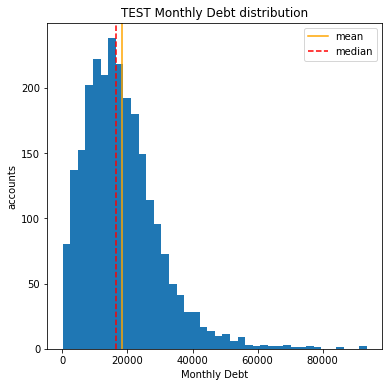

In [48]:
df_test_base['Monthly Debt'].hist(figsize=(6, 6), bins=40, grid=False)
plt.axvline(x=df_test_base['Monthly Debt'].mean(),
            label='mean', color='orange')
plt.axvline(x=df_test_base['Monthly Debt'].median(
), label='median', linestyle='--', color='red')
plt.ylabel('accounts')
plt.xlabel('Monthly Debt')
plt.title('TEST Monthly Debt distribution')
plt.legend()
plt.show()

In [49]:
Monthly_Debt_gap_filter = df_test_base['Monthly Debt'] > 60000
df_test_base.loc[Monthly_Debt_gap_filter]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
42,Rent,NaN,5 years,0.0,30.0,15.8,1661484.0,0.0,NaN,0.0,other,Long Term,296560.0,1093412.0,68721.0,NaN
176,Home Mortgage,3725900.0,5 years,0.0,22.0,27.5,5926250.0,0.0,0.0,0.0,debt consolidation,Long Term,754996.0,3209062.0,69550.0,686.0
253,Home Mortgage,3863840.0,10+ years,0.0,20.0,28.6,6381078.0,0.0,5.0,0.0,debt consolidation,Long Term,99999999.0,4304051.0,66973.0,727.0
285,Home Mortgage,5840220.0,10+ years,0.0,20.0,27.0,6425034.0,0.0,62.0,0.0,debt consolidation,Short Term,473374.0,4489054.0,84683.0,745.0
396,Home Mortgage,2728837.0,10+ years,0.0,18.0,15.5,2054228.0,0.0,20.0,0.0,debt consolidation,Short Term,99999999.0,439983.0,75498.0,737.0
435,Home Mortgage,2431772.0,2 years,0.0,11.0,18.4,6087290.0,0.0,NaN,0.0,other,Short Term,94600.0,3659001.0,69913.0,705.0
604,Home Mortgage,5979623.0,8 years,0.0,12.0,28.0,2450910.0,0.0,30.0,0.0,debt consolidation,Long Term,571494.0,2093401.0,62786.0,693.0
860,Home Mortgage,8057178.0,10+ years,2.0,17.0,27.4,1894508.0,2.0,NaN,0.0,debt consolidation,Long Term,762916.0,1600180.0,73186.0,609.0
909,Home Mortgage,3412476.0,10+ years,0.0,16.0,16.6,1395724.0,0.0,NaN,0.0,debt consolidation,Long Term,768306.0,990831.0,65121.0,671.0
963,Rent,3238721.0,2 years,0.0,12.0,18.7,2673462.0,0.0,NaN,0.0,debt consolidation,Short Term,370590.0,2200390.0,92574.0,726.0


**В тестовом (TEST) сете выбросы в тех же признаках, что и в обучающем(TRAIN):**<br>
 - 297 значений в признаке `Current Loan Amount`равные 99 999 999.0;
 - 160 значений признака `Credit Score` более 1000;
 - 63 значений `Current Credit Balance` более 1 000 000;
 - 18 значений `Monthly Debt` более 60 000.

Алгоритм бработки выбросов аналогичен обучающей выборке.

#### Анализ категориальных признаков

In [50]:
for cat_colname in df_train_base.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' +
          str(df_train_base[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

В целом тестовая и обучающая выборки сопоставимы по признакам. Имеют одинаковые проблемы с выбросами и пропусками. Следовательно могут обрабатываться одинаково.

### Анализ признакового пространства
#### Матрица корреляции признаков для обучающей выборки

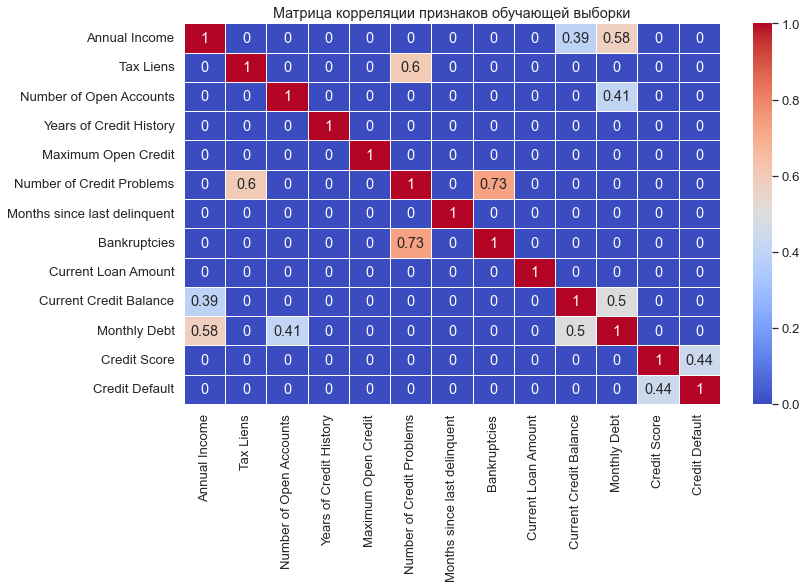

In [51]:
plt.figure(figsize=(12, 7))

sns.set(font_scale=1.2)

corr_matrix = df_train_base.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Матрица корреляции признаков обучающей выборки')
plt.show()

Видим сильную корреляцию ($\geq 0,5$) следующих признаков:
 - `'Number of Credit Problems'` $\iff$ `'Bankruptcies'` $=0,73$
 - `'Annual Income'` $\iff$ `'Monthly Debt'` $=0,58$
 - `'Tax Liens'` $\iff$ `'Number of Credit Problems'` $=0,6$
 - `'Monthly Debt'` $\iff$ `'Current Credit Balance'` $=0,5$

#### Матрица корреляции признаков для тестовой выборки

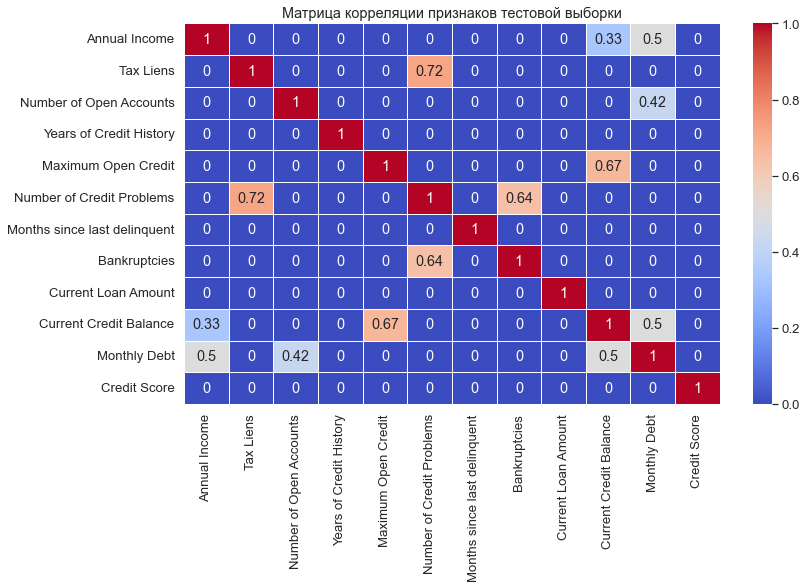

In [52]:
plt.figure(figsize=(12, 7))

sns.set(font_scale=1.2)

corr_matrix = df_test_base.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Матрица корреляции признаков тестовой выборки')
plt.show()

Сильная ($\geq 0,5$) корреляция сохраняется на том же уровне на тех же признаках, что и в обучающем сете:
 - `'Number of Credit Problems'` $\iff$ `'Bankruptcies'` $=0,64$
 - `'Annual Income'` $\iff$ `'Monthly Debt'` $=0,5$
 - `'Tax Liens'` $\iff$ `'Number of Credit Problems'` $=0,72$
 - `'Monthly Debt'` $\iff$ `'Current Credit Balance'` $=0,5$

Кроме того добавилась корреляция на признаках `'Current Credit Balance'` $\iff$ `'Maximum Open Credit'` $=0,67$

Используя матрицы корреляции признаков можно сократить их количество путем объединения во время финальной доработки модели. Тем самым мы понизим размерность, что позволит ускорить работу модели и снизит сложность обработки.

## Предварительная обработка признаков

Перед обработкой данных скопируем сеты в новые переменные и дальнейшие манипуляции будем проводить с ними.

In [113]:
df_train = df_train_base.copy()
df_test = df_test_base.copy()

### Обработка категориальных признаков

`Home Ownership` и `Purpose` преведем в цифру вероятности возврата кредита, `Years in current job` переведем в численные значения, `Term` сделаем бинарным.

In [114]:
df_cat = df_train.groupby('Home Ownership', as_index=False).mean()[['Home Ownership', 'Credit Default']].rename(columns={
    'Credit Default': 'target_Home_Ownership'
})
df_cat = pd.DataFrame(df_cat)

df_train = df_train.merge(df_cat, on='Home Ownership', how='left')
df_test = df_test_base.merge(df_cat, on='Home Ownership', how='left')
df_train['Years in current job'] = df_train['Years in current job'].replace({'< 1 year': 0, '1 year': 1, '2 years': 2,
                                                                             '3 years': 3, '4 years': 4, '5 years': 5,
                                                                             '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10})

df_test['Years in current job'] = df_test['Years in current job'].replace({'< 1 year': 0, '1 year': 1, '2 years': 2,
                                                                           '3 years': 3, '4 years': 4, '5 years': 5,
                                                                           '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10})
df_cat = df_train.groupby('Purpose', as_index=False).mean()[['Purpose', 'Credit Default']].rename(columns={
    'Credit Default': 'target_Purpose'})
df_cat = pd.DataFrame(df_cat)
df_train = df_train.merge(df_cat, on='Purpose', how='left')
df_test = df_test.merge(df_cat, on='Purpose', how='left')

df_train['Term'] = df_train['Term'].map(
    {'Long Term': '1', 'Short Term': '2'}).astype(int)
df_test['Term'] = df_test['Term'].map(
    {'Long Term': '1', 'Short Term': '2'}).astype(int)

### Обработка выбросов

 - Выбросы `Credit Score` делим на 10.
 - Выбросы в `Current Loan Amount, Maximum Open Credit` заменяем на `NaN` и затем обрабатывем как пропуски.
 - Выбросы в `Current Credit Balance, Monthly Debt` пока не трогаем. Если понадобится - вернемся к ним в дальнейшем.

In [115]:
OUTLIER_VALUES_FEATURE_NAMES = ['Maximum Open Credit', 'Current Loan Amount',
                                'Current Credit Balance', 'Monthly Debt', 'Credit Score']

In [116]:
df_train.loc[df_train['Credit Score'] > 1000, 'Credit Score'] = df_train['Credit Score'] / 10
df_test.loc[df_test['Credit Score'] > 1000, 'Credit Score'] = df_test['Credit Score'] / 10

In [117]:
# использование threshold=99 999 000 позволяет обработать только признаки
# 'Maximum Open Credit' и 'Current Loan Amount', не затрагивая остальные
for feature_name in OUTLIER_VALUES_FEATURE_NAMES:
    df_train = preprocess_outlier_values(df_train, feature_name, threshold=99999000)
    df_test = preprocess_outlier_values(df_test, feature_name, threshold=99999000)
    print('TRAIN' + '   ' + str(feature_name) + ': ' + str(df_train[feature_name].isna().sum()))
    print('TEST' + '   ' + str(feature_name) + ': ' + str(df_test[feature_name].isna().sum()) + '\n')

TRAIN   Maximum Open Credit: 3
TEST   Maximum Open Credit: 0

TRAIN   Current Loan Amount: 870
TEST   Current Loan Amount: 297

TRAIN   Current Credit Balance: 0
TEST   Current Credit Balance: 0

TRAIN   Monthly Debt: 0
TEST   Monthly Debt: 0

TRAIN   Credit Score: 1557
TEST   Credit Score: 513



In [118]:
# feature_name = 'Maximum Open Credit'
# df_train = preprocess_outlier_values(df_train, feature_name, threshold=10000000)
# df_test = preprocess_outlier_values(df_test, feature_name, threshold=10000000)

# print('TRAIN' + '   ' + str(feature_name) + ': ' + str(df_train[feature_name].isna().sum()))
# print('TEST' + '   ' + str(feature_name) + ': ' + str(df_test[feature_name].isna().sum()))

### Обработка пропусков

In [124]:
for num_colname in df_train.select_dtypes(include='float64').columns:
    if df_train[num_colname].isna().sum() > 0:
        print('TRAIN' + '   ' + str(num_colname) + ': ' + str(df_train[num_colname].isna().sum()) + ' NaN values')

TRAIN   Annual Income: 1557 NaN values
TRAIN   Years in current job: 371 NaN values
TRAIN   Maximum Open Credit: 3 NaN values
TRAIN   Months since last delinquent: 4081 NaN values
TRAIN   Bankruptcies: 14 NaN values
TRAIN   Current Loan Amount: 870 NaN values
TRAIN   Credit Score: 1557 NaN values


In [125]:
for num_colname in df_test.select_dtypes(include='float64').columns:
    if df_test[num_colname].isna().sum() > 0:
        print('TRAIN' + '   ' + str(num_colname) + ': ' + str(df_test[num_colname].isna().sum()) + ' NaN values')

TRAIN   Annual Income: 513 NaN values
TRAIN   Years in current job: 86 NaN values
TRAIN   Months since last delinquent: 1358 NaN values
TRAIN   Bankruptcies: 3 NaN values
TRAIN   Current Loan Amount: 297 NaN values
TRAIN   Credit Score: 513 NaN values


In [126]:
MISSED_VALUES_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Maximum Open Credit', 'Months since last delinquent',
                               'Bankruptcies', 'Current Loan Amount', 'Credit Score']

#### Выделение целевой переменной и групп признаков

In [127]:
TARGET_NAME_PROCESS = 'Credit Default'

NUM_FEATURE_NAMES_PROCESS = ['Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                             'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                             'Bankruptcies', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                             'Credit Score', 'target_Home_Ownership', 'target_Purpose']

CAT_FEATURE_NAMES_PROCESS = ['Home Ownership', 'Purpose']

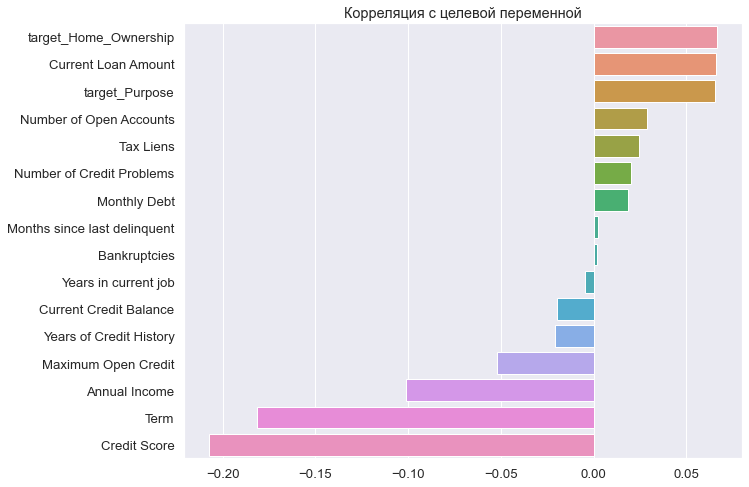

In [128]:
corr_with_target = df_train[NUM_FEATURE_NAMES_PROCESS + [TARGET_NAME_PROCESS]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Корреляция с целевой переменной')
plt.show()

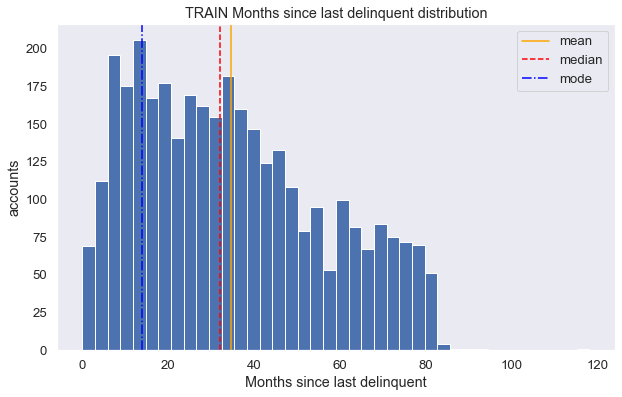

In [129]:
df_train['Months since last delinquent'].hist(figsize=(10, 6), bins=40, grid=False)
plt.axvline(x=df_train['Months since last delinquent'].mean(), label='mean', color='orange')
plt.axvline(x=df_train['Months since last delinquent'].median(), label='median', linestyle='--', color='red')
plt.axvline(x=df_train['Months since last delinquent'].mode()[0], label='mode', linestyle='-.', color='blue')
plt.ylabel('accounts')
plt.xlabel('Months since last delinquent')
plt.title('TRAIN Months since last delinquent distribution')
plt.legend()
plt.show()

**Обработка пропусков**
1. После обработки категориальных признаков и обработки выбросов корреляция `Credit Default и Credit Score` стала обратной, а `Credit Default/Current Loan Amount` стала прямой. Возможно это связано с тем, что мы убрали выбросы из значимых признаков.
2. Исходя из данных о корреляции признаков пропуски в `Annual Income, Credit Score, Current Loan Amount, Maximum Open Credit` оказывают большое влияние на целевую переменную. В связи с этим, а также с большим количеством (870 и 1557) пропусков в этих признаках замена пропусков на среднее/моду/медиану может внести большую ошибку при построении модели. Следовательно для заполнения мы будем использовать случайный лес (`RandomForestRegressor`).
3. Признаки `Months since last delinquent, Bankruptcies` и `Years in current job` мало коррелируют с целевой переменной и не оказывают значимого влияния. К тому же пропуски в них относительно малочисленны (кроме `Months since last delinquent` - 4081). Заполним пропуски в этих признаках следующим образом:
 - пропуски в `Bankruptcies` заменим медианой
 - пропуски в `Years in current job` заменим модой
 <span class="burk">- пропуски в `Months since last delinquent` заменим средним, модой и медианой примерно в равных пропорциях ввиду большого их количества</span>

In [130]:
df_train.loc[df_train['Bankruptcies'].isna(), 'Bankruptcies'] = df_train['Bankruptcies'].median()
df_test.loc[df_test['Bankruptcies'].isna(), 'Bankruptcies'] = df_test['Bankruptcies'].median()

df_train.loc[df_train['Years in current job'].isna(), 'Years in current job'] = df_train['Years in current job'].mode()[0]
df_test.loc[df_test['Years in current job'].isna(), 'Years in current job'] = df_test['Years in current job'].mode()[0]

In [ ]:
df = df_train.copy()

In [ ]:
df.loc[df['Months since last delinquent'].isna(
), 'Months since last delinquent'] = df['Months since last delinquent'].mode()[0]

In [ ]:
# Создадим цикл, в котором будем заменять пропуски в Months since last delinquent средним, модой и медианой
# в зависимости от счетчика пустых значений

#count = int(df['Months since last delinquent'].isna().sum())
count = 0
print(count)

In [ ]:
print(type(count))

In [ ]:
month_delinq = list(df['Months since last delinquent'])
print(month_delinq)

In [ ]:
count = 0
for non_num in list(df['Months since last delinquent']):
    if 0 >= count > 1361:
        non_num = df['Months since last delinquent'].median()
        count += 1
for non_num in list(df['Months since last delinquent']):
    if type(non_num) == 'NaN' and count < 1361:
        non_num = df['Months since last delinquent'].median()
        count -= 1
#    elif nan

In [ ]:
df['Months since last delinquent'].isna().sum()

In [ ]:
print(count)

In [ ]:
if df['Months since last delinquent'].isna().sum() > 2721:
    df.loc[df['Months since last delinquent'].isna().sum() > 2721, 'Months since last delinquent'] = df['Months since last delinquent'].median()
# if df_train[num_colname].isna().sum() > 2721:
#     df_train.loc[df_train['Months since last delinquent'].isna(), 'Months since last delinquent'] = df_train['Months since last delinquent'].median()
# df_test.loc[df_test['Months since last delinquent'].isna(), 'Months since last delinquent'] = df_test['Months since last delinquent'].median()

In [ ]:
df.info()

In [ ]:
print(df['Months since last delinquent'])

In [ ]:
df['Months since last delinquent'].value_counts()

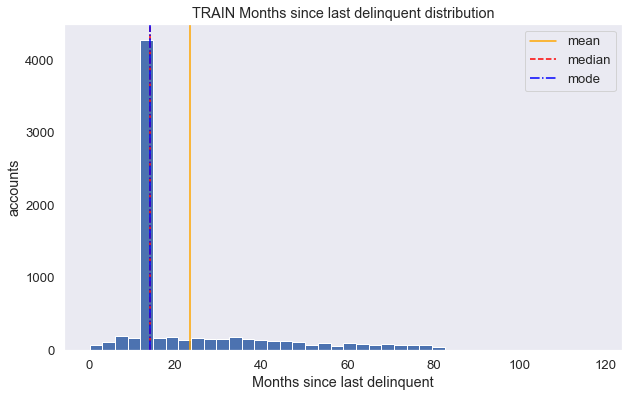

In [189]:
df['Months since last delinquent'].hist(figsize=(10, 6), bins=40, grid=False)
plt.axvline(x=df['Months since last delinquent'].mean(), label='mean', color='orange')
plt.axvline(x=df['Months since last delinquent'].median(), label='median', linestyle='--', color='red')
plt.axvline(x=df['Months since last delinquent'].mode()[0], label='mode', linestyle='-.', color='blue')
plt.ylabel('accounts')
plt.xlabel('Months since last delinquent')
plt.title('TRAIN Months since last delinquent distribution')
plt.legend()
plt.show()

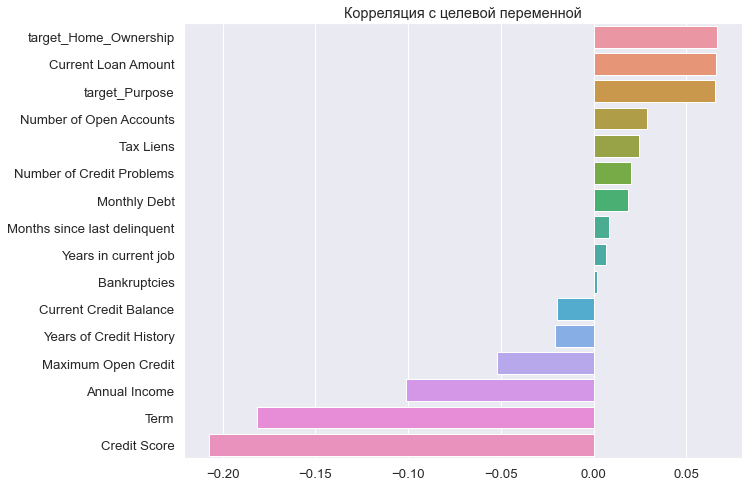

In [190]:
corr_with_target = df[NUM_FEATURE_NAMES_PROCESS + [TARGET_NAME_PROCESS]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Корреляция с целевой переменной')
plt.show()

In [191]:
for num_colname in df_test.select_dtypes(include='float64').columns:
    if df[num_colname].isna().sum() > 0:
        print('TRAIN' + '   ' + str(num_colname) + ': ' + str(df[num_colname].isna().sum()) + ' NaN values')

TRAIN   Annual Income: 1557 NaN values
TRAIN   Maximum Open Credit: 3 NaN values
TRAIN   Current Loan Amount: 870 NaN values
TRAIN   Credit Score: 1557 NaN values


In [2]:
#df_test[OUTLIER_VALUES_FEATURE_NAMES].hist(figsize=(20, 20), bins=40, grid=False);

In [ ]:
df_train.loc[df_train['Annual Income'].isna(), 'Annual Income'] = df_train['Annual Income'].median()
df_test.loc[df_test['Annual Income'].isna(), 'Annual Income'] = df_test['Annual Income'].median()

df_train.loc[df_train['Months since last delinquent'].isna(), 'Months since last delinquent'] = df_train['Months since last delinquent'].median()
df_test.loc[df_test['Months since last delinquent'].isna(), 'Months since last delinquent'] = df_test['Months since last delinquent'].median()

df_train.loc[df_train['Bankruptcies'].isna(), 'Bankruptcies'] = df_train['Bankruptcies'].median()
df_test.loc[df_test['Bankruptcies'].isna(), 'Bankruptcies'] = df_test['Bankruptcies'].median()

df_train.loc[df_train['Years in current job'].isna(), 'Years in current job'] = df_train['Years in current job'].mode()[0]
df_test.loc[df_test['Years in current job'].isna(), 'Years in current job'] = df_test['Years in current job'].mode()[0]

In [ ]:
# TARGET_NAME = 'Credit Default'

# NUM_FEATURE_NAMES_BASE = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
#                      'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
#                      'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
#                      'Credit Score']

# CAT_FEATURE_NAMES_BASE = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [64]:
df_train['Months since last delinquent'].value_counts()

14.0     76
29.0     71
33.0     68
8.0      68
12.0     65
         ..
86.0      1
118.0     1
84.0      1
91.0      1
92.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

In [ ]:
df_test['Years in current job'].value_counts()

In [ ]:
df_test['Years in current job'].value_counts()

In [ ]:
df_train.info()

In [ ]:
df_test.info()

### Сохранение подготовленных датасетов в файлы.

In [ ]:
df_train.to_csv('train_prep.csv', index=False)
df_test.to_csv('test_prep.csv', index=False)

In [ ]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

## Построение базовых моделей

#### Генерация новых признаков

Создадим категории для Monthly Debt и сделаем признак вероятности возврата кредита по этим категориям.

In [ ]:
df_try = df_train.copy()
# df_test = Monthly_Debt_cat(df_test)

In [ ]:
df_try.head()

In [ ]:
df_cat = df_train.groupby('Monthly_Debt', as_index=False).mean()[['Monthly_Debt', 'Credit Default']].rename(columns={
    'Credit Default': 'target_Monthly_Debt'
})
df_cat = pd.DataFrame(df_cat)

df_try = df_try.merge(df_cat, on='Monthly_Debt', how='left')
# df_test = df_test.merge(df_cat, on='Monthly_Debt', how='left')

In [ ]:
df_train.info()

In [ ]:
df_test.info()

In [ ]:
df_train.info()